http://www.nature.com/news/interactive-notebooks-sharing-the-code-1.16261

'What Tool':
https://engineering.purdue.edu/~what/compute_r2_nash_sutcliffe.html

Nash-Sutcliffe Paper:
http://www.sciencedirect.com/science/article/pii/0022169470902556

In [1]:
%matplotlib inline
from netCDF4 import Dataset, num2date
from pandas import Series
from capstone_util import run_prms

try:
    d.close()
except:
    pass

data_file = 'data_2station_calib.nc'

d = Dataset('data/data.nc')
t = d.variables['time']
tv = t[:]
datev = num2date(tv, t.units)

print d
print t

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Date File
    nsteps: 1
    bands_name: nsteps
    bands_desc: Variable information for Data File
    dimensions(sizes): time(7160)
    variables(dimensions): int32 time(time), float32 tmax_1(time), float32 tmax_2(time), float32 tmin_1(time), float32 tmin_2(time), float32 precip_1(time), float32 precip_2(time), float32 runoff_1(time), float32 runoff_2(time), float32 runoff_3(time), float32 runoff_4(time), float32 runoff_5(time)
    groups: 

<type 'netCDF4._netCDF4.Variable'>
int32 time(time)
    long_name: time
    units: days since 1988-10-1 0:0:0
unlimited dimensions: 
current shape = (7160,)
filling on, default _FillValue of -2147483647 used



/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


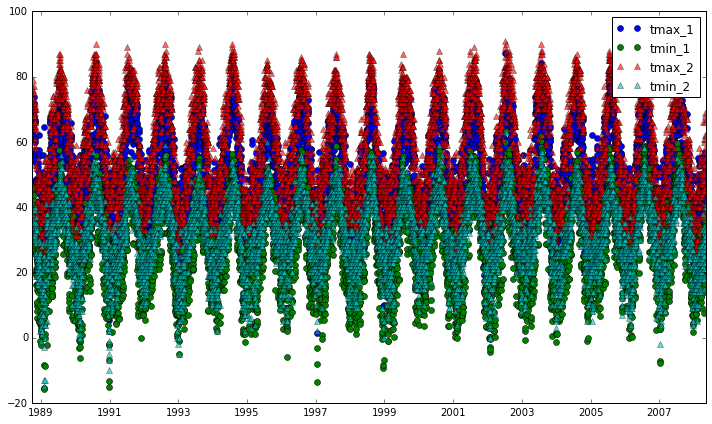

In [2]:
# Plot it fancy-like
import matplotlib.pyplot as plt
import numpy as np

vrs = d.variables
tmax1v = Series(vrs['tmax_1'][:])
tmin1v = Series(vrs['tmin_1'][:])
tmax2v = Series(vrs['tmax_2'][:])
tmin2v = Series(vrs['tmin_2'][:])

tmax1v[np.isclose(tmax1v, -999.)] = np.nan
tmax2v[np.isclose(tmax2v, -999.)] = np.nan
tmin1v[np.isclose(tmin1v, -999.)] = np.nan
tmin2v[np.isclose(tmin2v, -999.)] = np.nan

tmax1v.interpolate(inplace=True)
tmin1v.interpolate(inplace=True)
tmax2v.interpolate(inplace=True)
tmin2v.interpolate(inplace=True)


fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plt.plot(datev, tmax1v, marker='o', ls='', label='tmax_1')
plt.plot(datev, tmin1v, marker='o', ls='', label='tmin_1')
plt.plot(datev, tmax2v, marker='^', ls='', label='tmax_2', alpha=0.6)
plt.plot(datev, tmin2v, marker='^', ls='', label='tmin_2', alpha=0.6)
plt.legend()

## Use the Virtual Watershed modeling service to run PRMS using "base" data

This data comes from the paper [Huntington, J. L., and R. G. Niswonger (2012), Role of surface-water and groundwater interactions on projected summertime streamflow in snow dominated regions: An integrated modeling approach, Water Resour. Res., 48, W11524, doi:10.1029/2012WR012319](./Huntington_et_al-2012-Water_Resources_Research.pdf). We have transformed the PRMS text file format to netCDF to demonstrate the use of Virtual Watershed tools. We also want to emphasize that PRMS input files can begin their existance as netCDF files that are much easier to create and use given the powerful ecosystem of tools built around netCDF.

### Get your authentication token from https://auth-test.virtualwatershed.org

Please register at https://auth-test.virtualwatershed.org. After you've confirmed your email address, return to the authorization site and click on the API Key, and copy the key below. The first part of the `try/except` block is useful if you are running this notebook on your own computer. Instead of writing the token here you could just import it from another file.

In [6]:
try:
    from jwt import TOKEN
except ImportError:
    TOKEN = 'put your token here'
    

# run the base PRMS with Incline Village data
output_dir = 'base-iv-run'
run_prms('data/data.nc', 'data/parameter.nc', 'data/incline_village.control', 
         TOKEN, output_dir, modelrun_title='Base Incline Village Modelrun')

uploading data
uploading param
uploading control
starting modelrun
getting state...
state: RUNNING
getting state...
state: RUNNING
event: nc_to_data
getting state...
state: RUNNING
event: nc_to_parameter
getting state...
state: RUNNING
event: running_prms
getting state...
state: RUNNING
event: nc_to_data
getting state...
state: RUNNING
event: nc_to_data
getting state...
state: RUNNING
event: nc_to_data
getting state...
state: RUNNING
event: nc_to_data
getting state...
state: RUNNING
event: nc_to_data
getting state...
state: RUNNING
event: nc_to_data
getting state...
state: RUNNING
event: nc_to_data
getting state...
state: RUNNING
event: nc_to_data
getting state...
state: RUNNING
event: nc_to_data
getting state...
state: RUNNING
event: nc_to_data
getting state...
state: RUNNING
event: nc_to_data
getting state...
state: RUNNING
event: nc_to_data
getting state...
state: RUNNING
event: nc_to_data
getting state...
state: RUNNING
event: nc_to_data
getting state...
state: RUNNING
event: nc_to

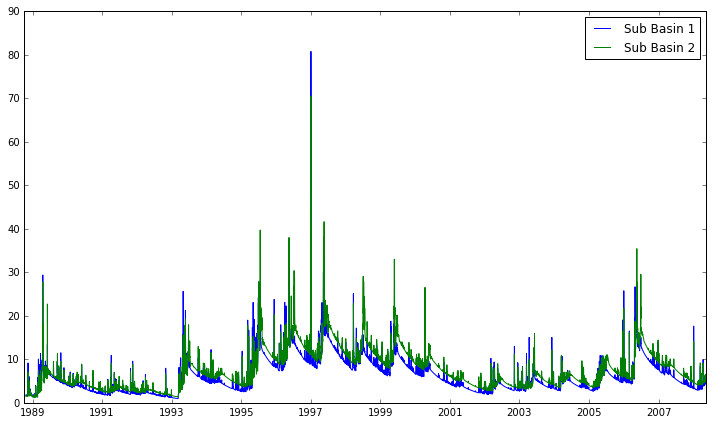

In [29]:
d = Dataset('base-iv-run/statsvar.nc')

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

t = d.variables['time']
tv = t[:]
datev = num2date(tv, t.units)
q1v = d.variables['sub_cfs_1'][:]
q2v = d.variables['sub_cfs_2'][:]
plt.plot(datev, q1v, label='Sub Basin 1')
plt.plot(datev, q2v, label='Sub Basin 2')
plt.legend()

## Modify temperature in data file and visualize results

In [3]:
from capstone_util import create_prms_scenario_inputs, temperature_scaling_fun_generator

# generate a function that will multiply all temperature timeseries by 1.1
temp_scale_factor = 1.1
f = temperature_scaling_fun_generator(temp_scale_factor, temp_vars=['tmax_1', 'tmin_1', 'tmax_2', 'tmin_2'])

# pass this function as an argument to create_prms_scenario_inputs
create_prms_scenario_inputs('data/data.nc', 'data/parameter.nc', 
                            'data/incline_village.control', 
                            'first-iv-scenario', data_mod_fun=f)

In [4]:
# now run prms with the scenario inputs
TOKEN = ''
run_prms('first-iv-scenario/data.nc', 'first-iv-scenario/parameter.nc', 
         'first-iv-scenario/incline_village.control', TOKEN, 'first-iv-scenario-outputs', 
         modelrun_title='First IV Scenario')

NameError: name 'TOKEN' is not defined

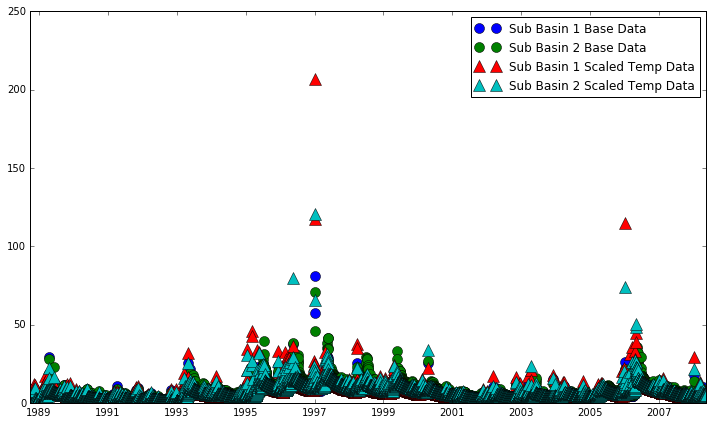

In [44]:
dscale = Dataset('first-iv-scenario-outputs/statsvar.nc')
t = dscale.variables['time']
tv = t[:]
datev = num2date(tv, t.units)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

q1basev = d.variables['sub_cfs_1'][:]
q2basev = d.variables['sub_cfs_2'][:]

q1scalev = dscale.variables['sub_cfs_1'][:]
q2scalev = dscale.variables['sub_cfs_2'][:]

plt.plot(datev, q1basev, marker='o', ls='', ms=10, label='Sub Basin 1 Base Data')
plt.plot(datev, q2basev, marker='o', ls='', ms=10, label='Sub Basin 2 Base Data')
plt.plot(datev, q1scalev, marker='^', ls='', ms=12, label='Sub Basin 1 Scaled Temp Data')
plt.plot(datev, q2scalev, marker='^', ls='', ms=12, label='Sub Basin 2 Scaled Temp Data')

# plt.ylim([0, ])

plt.legend()

### xarray for plotting datasets

We can't use xarray for modifying datasets because of how it saves dates. However it does provide nice functionality for resampling and plotting timeseries data. We'll make the same plot as above, but a little nicer by resampling the daily data to a longer timestep and taking the average over the longer timestep.

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


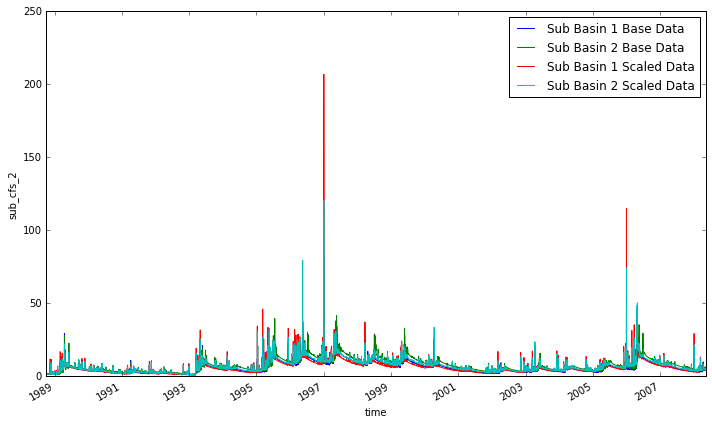

In [4]:
from datetime import datetime
from xarray import open_dataset

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

db = open_dataset('base-iv-run/statsvar.nc')
dsc = open_dataset('first-iv-scenario-outputs/statsvar.nc')

resample_offset = '2W'
time_slice = slice(datetime(1996, 10, 1), datetime(2000, 9, 30))

db.sub_cfs_1.plot(label='Sub Basin 1 Base Data')
db.sub_cfs_2.plot(label='Sub Basin 2 Base Data')
dsc.sub_cfs_1.plot(label='Sub Basin 1 Scaled Data')
dsc.sub_cfs_2.plot(label='Sub Basin 2 Scaled Data')
plt.legend()

### A more professional and informative plot

This is something, but not very good. There are many issues with the graph, not least of which is it's very difficult to get much intuition about what's happening. We can start to see a few rough details, like 

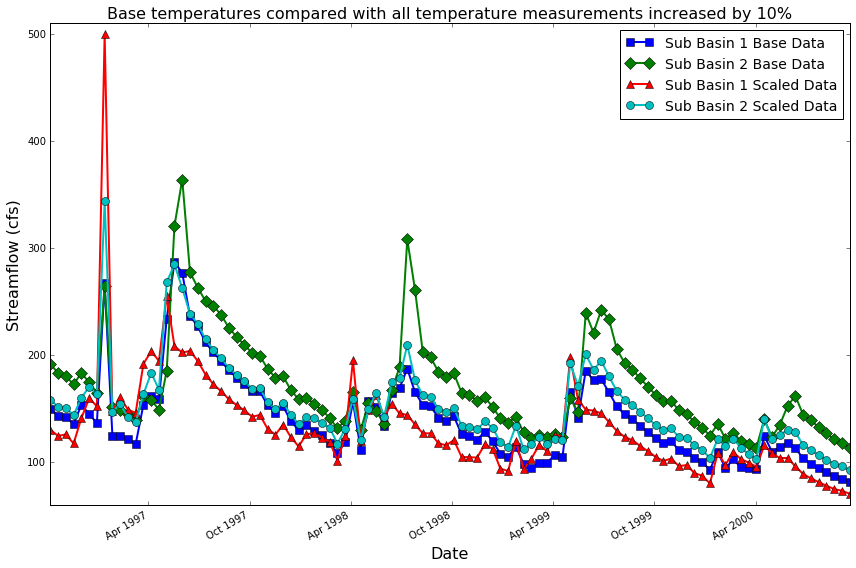

In [44]:
from datetime import datetime
from xarray import open_dataset

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# resample over two weeks
resample_offset = '2W'
# 
time_slice = slice(datetime(1996, 10, 1), datetime(2000, 9, 30))
# specify method for resampling: could be 'mean', 'sum', 'min', 'max', 'median'
# see docs for more: http://xarray.pydata.org/en/stable/generated/xarray.DataArray.resample.html#xarray-dataarray-resample
how = 'sum'


db.sub_cfs_1.resample(resample_offset, 'time', how=how).loc[time_slice].plot(marker='s', ms=8, lw=2, label='Sub Basin 1 Base Data')
db.sub_cfs_2.resample(resample_offset, 'time', how=how).loc[time_slice].plot(marker='D', ms=8, lw=2, label='Sub Basin 2 Base Data')
dsc.sub_cfs_1.resample(resample_offset, 'time', how=how).loc[time_slice].plot(marker='^', ms=8, lw=2, label='Sub Basin 1 Scaled Data')
dsc.sub_cfs_2.resample(resample_offset, 'time', how=how).loc[time_slice].plot(marker='o', ms=8, lw=2, label='Sub Basin 2 Scaled Data')

plt.ylabel('Streamflow (cfs)', size=16)
plt.ylim([60, 510])
plt.xlabel('Date', size=16)
plt.title('Base temperatures compared with all temperature measurements increased by 10%', size=16)
plt.legend(fontsize=14)

#db.close()
#dsc.close()

## Extracting more streamflow information: timing of peak and total streamflow in a water year

Major things we want to know are where water goes and when does it go. In the next section we show how to see how much water flowed in the stream in each water year and when the peak streamflow occurred.
            

### Timing of peak streamflow in a water year

Now we will show how to find and compare the time of peak stream flow in every water year and compare them in a table. We can output LaTeX for easily inclusion in a publication.

In [14]:
import pprint
print db.time[-1]
wy_slices = {
    str(year+1): slice(datetime(year, 10, 1), datetime(year+1, 10, 1))
    for year in range(1988, 2008)
}

pprint.pprint(wy_slices)

<xarray.DataArray 'time' ()>
numpy.datetime64('2008-05-09T00:00:00.000000000')
Coordinates:
    time     datetime64[ns] 2008-05-09
Attributes:
    long_name: time
{'1989': slice(datetime.datetime(1988, 10, 1, 0, 0), datetime.datetime(1989, 10, 1, 0, 0), None),
 '1990': slice(datetime.datetime(1989, 10, 1, 0, 0), datetime.datetime(1990, 10, 1, 0, 0), None),
 '1991': slice(datetime.datetime(1990, 10, 1, 0, 0), datetime.datetime(1991, 10, 1, 0, 0), None),
 '1992': slice(datetime.datetime(1991, 10, 1, 0, 0), datetime.datetime(1992, 10, 1, 0, 0), None),
 '1993': slice(datetime.datetime(1992, 10, 1, 0, 0), datetime.datetime(1993, 10, 1, 0, 0), None),
 '1994': slice(datetime.datetime(1993, 10, 1, 0, 0), datetime.datetime(1994, 10, 1, 0, 0), None),
 '1995': slice(datetime.datetime(1994, 10, 1, 0, 0), datetime.datetime(1995, 10, 1, 0, 0), None),
 '1996': slice(datetime.datetime(1995, 10, 1, 0, 0), datetime.datetime(1996, 10, 1, 0, 0), None),
 '1997': slice(datetime.datetime(1996, 10, 1, 0, 0), 

In [64]:
# set up a DataFrame to hold the results of our tally of peak streamflow timing
from pandas import DataFrame

cols = ['sb1_base', 'sb1_hotter', 'sb2_base', 'sb2_hotter']
timing_df = DataFrame(index=range(1989, 2009), columns=cols)

s = None
for wy, wy_slice in wy_slices.iteritems():
    for col in cols:
        if col in ['sb1_base', 'sb2_base']:
            if '1' in col:
                s = db.sub_cfs_1
            elif '2' in col:
                s = db.sub_cfs_2
        elif col in ['sb1_hotter', 'sb2_hotter']:
            if '1' in col:
                s = dsc.sub_cfs_1
            elif '2' in col:
                s = dsc.sub_cfs_2
        
        s = s.loc[wy_slice].to_series()
        timing_df.ix[int(wy)][col] = s.argmax()

        
print timing_df

                 sb1_base           sb1_hotter             sb2_base  \
1989  1989-04-18 00:00:00  1989-03-03 00:00:00  1989-04-18 00:00:00   
1990  1989-10-24 00:00:00  1989-11-26 00:00:00  1989-10-24 00:00:00   
1991  1991-04-07 00:00:00  1991-03-04 00:00:00  1991-04-07 00:00:00   
1992  1991-11-18 00:00:00  1991-11-18 00:00:00  1991-11-18 00:00:00   
1993  1993-05-01 00:00:00  1993-05-01 00:00:00  1993-05-25 00:00:00   
1994  1994-02-18 00:00:00  1994-02-18 00:00:00  1993-10-06 00:00:00   
1995  1995-07-04 00:00:00  1995-03-10 00:00:00  1995-07-19 00:00:00   
1996  1996-05-17 00:00:00  1996-05-17 00:00:00  1996-05-17 00:00:00   
1997  1997-01-02 00:00:00  1997-01-02 00:00:00  1997-01-02 00:00:00   
1998  1998-03-24 00:00:00  1998-03-24 00:00:00  1998-07-05 00:00:00   
1999  1999-05-28 00:00:00  1999-04-27 00:00:00  1999-05-28 00:00:00   
2000  2000-04-14 00:00:00  2000-04-14 00:00:00  2000-04-14 00:00:00   
2001  2000-10-29 00:00:00  2000-10-29 00:00:00  2000-10-29 00:00:00   
2002  

### Average timing difference (base - hotter)

In [72]:
sb1_diff = timing_df.sb1_base - timing_df.sb1_hotter

sb2_diff = timing_df.sb2_base - timing_df.sb2_hotter

print "SB 1 Mean Peak Streamflow Timing Difference: {}\n".format(sb1_diff.mean())

print "SB 2 Mean Peak Streamflow Timing Difference: {}\n".format(sb2_diff.mean())

SB 1 Mean Peak Streamflow Timing Difference: 22 days 19:12:00

SB 2 Mean Peak Streamflow Timing Difference: 13 days 04:48:00

